In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
from io import StringIO
%matplotlib inline
from functools import reduce
import numpy as np
import statsmodels.api as sm

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
#get geojson from nashville.gov
crime_endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.geojson'
#params to select for aggravated burglary and dates
crime_params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01\' and\'2021-06-30\'',
    '$limit': 2000
}
crime_response = requests.get(crime_endpoint, params = crime_params)

#convert dictionary to text and convert to dataframe with geopandas
crime = (gpd.read_file(StringIO(crime_response.text)))

#drop duplicates to prevent double counting incidents with multiple victims
crime = crime.drop_duplicates(subset = 'incident_number')

In [3]:
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 824 entries, 0 to 1045
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   victim_county_resident       799 non-null    object  
 1   zip_code                     141 non-null    object  
 2   victim_number                824 non-null    object  
 3   offense_nibrs                824 non-null    object  
 4   rpa                          767 non-null    object  
 5   latitude                     822 non-null    object  
 6   victim_race                  799 non-null    object  
 7   incident_number              824 non-null    object  
 8   investigation_status         824 non-null    object  
 9   offense_number               824 non-null    object  
 10  offense_description          824 non-null    object  
 11  longitude                    822 non-null    object  
 12  domestic_related             824 non-null    bool    
 

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [4]:
#download census tract file and place in data folder. Read the .shp in with Geopandas and assign to census_tract
census_tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')

#Clean up the data set to make merging for part 3 easier. 
census_tract = census_tract[census_tract['COUNTYFP']== '037']
census_tract = census_tract.rename(columns = {'TRACTCE': 'tract'})
census_tract = census_tract.to_crs('epsg:4326')

#confirm identical crs type
print(census_tract.crs)
print(crime.crs)

epsg:4326
epsg:4326


In [5]:
#join crime with census_tract
#changed how = 'right' to retain polygon geometry instead of point geometry. 
crime_census_tract = gpd.sjoin(crime, census_tract, how = 'right', op = 'within')
crime_census_tract = crime_census_tract[['incident_number','incident_reported', 'geometry', 'tract']]

#Find the census tract with the largest number of aggravated burglaries
crime_census_tract.groupby('tract')['incident_number'].nunique().nlargest(n=10)

tract
016300    53
016200    21
011001    20
019300    19
019500    19
014800    18
019003    17
013700    14
013300    12
015629    12
Name: incident_number, dtype: int64

In [6]:
crime_census_tract.columns

Index(['incident_number', 'incident_reported', 'geometry', 'tract'], dtype='object')

3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [7]:
#get API key
with open('../data/jg_census_API_key.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

In [8]:
#set up endpoint and params for population dataset
pop_endpoint = 'https://api.census.gov/data/2019/acs/acs5'
pop_params = {
    'get': 'B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
pop_response = requests.get(pop_endpoint, params = pop_params)            

In [9]:
#convert pop_response to json
pop_response = pop_response.json()
#create the dataframe and simplify the name.
pop = pd.DataFrame(data = pop_response[1:], columns = pop_response[0])
#convert population column to int and rename to something that at least looks like "population"
pop['B01001_001E'] = pop['B01001_001E'].astype(int)
pop = pop.rename(columns = {'B01001_001E': 'population'})

In [10]:
#set up endpoint and params for median income dataset 
income_endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
income_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
income_response = requests.get(income_endpoint, params = income_params)

In [11]:
income_response = income_response.json()
inc = pd.DataFrame(data = income_response[1:], columns = income_response[0])

#convert median income column to int
inc['S1901_C01_012E'] = inc['S1901_C01_012E'].astype(int)

#rename alphabet soup to something recognizable
inc = inc.rename(columns = {'S1901_C01_012E': 'Median Income'})

#Some median income values are extremely negative, which is impossible. Replace with NaN
inc['Median Income'] = inc['Median Income'].replace(-666666666, np.nan)

In [12]:
#https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes
#join the crime_census_tract geodataframe with the pop and inc dataframes.
data = [crime_census_tract, pop, inc]
crime_pop_inc = reduce(lambda left, right: pd.merge(left, right), data)

In [13]:
crime_pop_inc.head()

,incident_number,incident_reported,geometry,tract,population,state,county,Median Income
0,20210193617,2021-04-06T12:03:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
1,20210193565,2021-04-06T11:41:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
2,20210270239,2021-05-15T12:07:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
3,20210001419,2021-01-03T14:41:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0
4,20210042105,2021-01-22T10:58:00,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",010106,3397,47,037,63864.0


In [14]:
census_tract.head()

,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,+36.2610013,-086.8023491,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,+36.3444054,-086.8608396,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,47,037,010202,47037010202,102.02,Census Tract 102.02,G5020,S,68394934,77571,+36.3619781,-086.7746355,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,47,037,010104,47037010104,101.04,Census Tract 101.04,G5020,S,65057846,251504,+36.2918321,-086.8763469,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,47,037,013300,47037013300,133,Census Tract 133,G5020,S,2764220,0,+36.1597942,-086.8530466,"POLYGON ((-86.86843 36.16435, -86.86836 36.164..."


4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [15]:
#merge census_tract (polygon) with crime_pop_inc, create a new column for incident rate by dividing the incident number by the population
#create a new column for incidents per 1000 residents by multiplying incident rate by 1000
crime_pop_inc_by_census_tract = gpd.sjoin(crime_pop_inc, census_tract, op = 'within' )

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract[['incident_number', 'geometry', 'tract_left','population','Median Income']]

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract.rename(columns = {'tract_left': 'tract'})

crime_pop_inc_by_census_tract = crime_pop_inc_by_census_tract.groupby(by = ['tract', 'population', 'Median Income'],
                                                as_index = False)['incident_number'].nunique()
crime_pop_inc_by_census_tract['incident_rate'] = crime_pop_inc_by_census_tract['incident_number']/crime_pop_inc_by_census_tract['population']

crime_pop_inc_by_census_tract['incident_per_1000'] = crime_pop_inc_by_census_tract['incident_rate']*1000

In [16]:
#Merge the aggregated Crime population income with the census tract data.
choropleth_data = pd.merge(left = census_tract, right = crime_pop_inc_by_census_tract,  how = 'left' )
choropleth_data.head()



,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,population,Median Income,incident_number,incident_rate,incident_per_1000
0,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,+36.2610013,-086.8023491,"POLYGON ((-86.83089 36.26570, -86.83016 36.265...",3397.0,63864.0,7.0,0.002061,2.060642
1,47,037,010103,47037010103,101.03,Census Tract 101.03,G5020,S,48020418,61097,+36.3444054,-086.8608396,"POLYGON ((-86.91752 36.33976, -86.91747 36.339...",2533.0,70341.0,0.0,0.000000,0.000000
2,47,037,010202,47037010202,102.02,Census Tract 102.02,G5020,S,68394934,77571,+36.3619781,-086.7746355,"POLYGON ((-86.82482 36.33225, -86.82480 36.332...",3962.0,78750.0,0.0,0.000000,0.000000
3,47,037,010104,47037010104,101.04,Census Tract 101.04,G5020,S,65057846,251504,+36.2918321,-086.8763469,"POLYGON ((-86.97440 36.24991, -86.97244 36.252...",2955.0,64844.0,5.0,0.001692,1.692047
4,47,037,013300,47037013300,133,Census Tract 133,G5020,S,2764220,0,+36.1597942,-086.8530466,"POLYGON ((-86.86843 36.16435, -86.86836 36.164...",3997.0,69006.0,12.0,0.003002,3.002252


In [17]:
(choropleth_data['incident_per_1000']==0).sum()

12

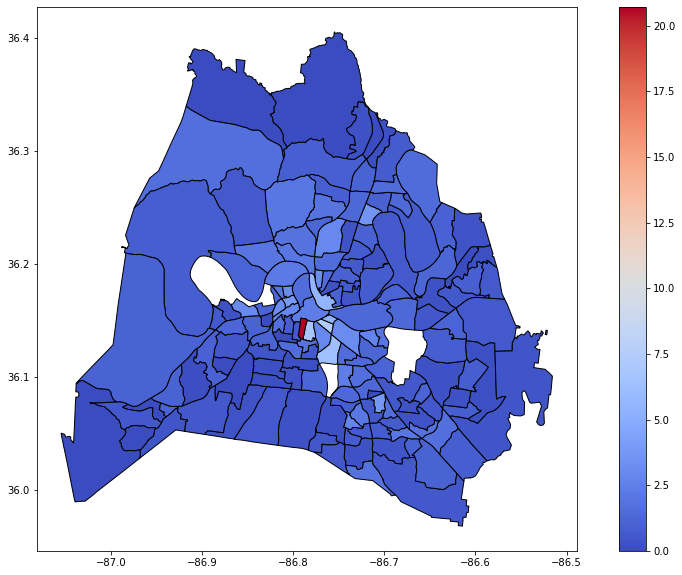

In [18]:
choropleth_data.plot(column = 'incident_per_1000',figsize = (15,10),
                    cmap = 'coolwarm',
                    edgecolor='black',
                    legend = True);

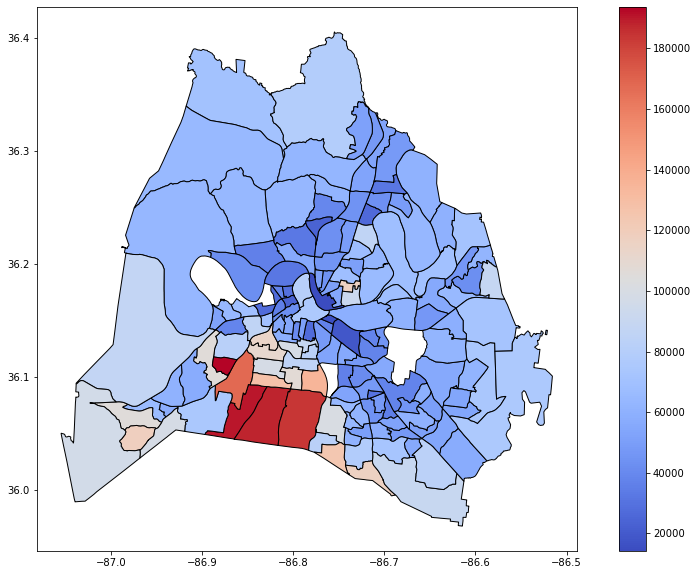

In [19]:
#not a part of the read.me but thought it would be cool to map median income too. 
choropleth_data.plot(column = 'Median Income',figsize = (15,10),
                    cmap = 'coolwarm',
                    edgecolor='black',
                    legend = True);

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

    a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

    b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

    c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

    d. How do your models compare? Hint: the fit models have an AIC attribute.

In [20]:
choropleth_data.columns

Index(['STATEFP', 'COUNTYFP', 'tract', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'population', 'Median Income', 'incident_number', 'incident_rate',
       'incident_per_1000'],
      dtype='object')

In [21]:
choropleth_data[choropleth_data['incident_per_1000']<20].corr()

,ALAND,AWATER,population,Median Income,incident_number,incident_rate,incident_per_1000
ALAND,1.000000,0.258609,0.176588,0.173150,-0.096046,-0.170984,-0.170984
AWATER,0.258609,1.000000,0.383275,0.028666,-0.015767,-0.098192,-0.098192
population,0.176588,0.383275,1.000000,0.032801,0.213997,-0.260689,-0.260689
Median Income,0.173150,0.028666,0.032801,1.000000,-0.384401,-0.408018,-0.408018
incident_number,-0.096046,-0.015767,0.213997,-0.384401,1.000000,0.766227,0.766227
incident_rate,-0.170984,-0.098192,-0.260689,-0.408018,0.766227,1.000000,1.000000
incident_per_1000,-0.170984,-0.098192,-0.260689,-0.408018,0.766227,1.000000,1.000000


In [22]:
choropleth_data['incident_per_1000'].sort_values(ascending = False)

89     20.703125
76      7.407407
77      6.831490
127     6.306938
115     5.542590
         ...    
159     0.000000
7            NaN
33           NaN
36           NaN
110          NaN
Name: incident_per_1000, Length: 161, dtype: float64

In [23]:
choropleth_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   STATEFP            161 non-null    object  
 1   COUNTYFP           161 non-null    object  
 2   tract              161 non-null    object  
 3   GEOID              161 non-null    object  
 4   NAME               161 non-null    object  
 5   NAMELSAD           161 non-null    object  
 6   MTFCC              161 non-null    object  
 7   FUNCSTAT           161 non-null    object  
 8   ALAND              161 non-null    int64   
 9   AWATER             161 non-null    int64   
 10  INTPTLAT           161 non-null    object  
 11  INTPTLON           161 non-null    object  
 12  geometry           161 non-null    geometry
 13  population         157 non-null    float64 
 14  Median Income      157 non-null    float64 
 15  incident_number    157 non-null    float64 
 16  

In [24]:
base_model = (sm.GLM(endog = crime_pop_inc_by_census_tract['incident_per_1000'],
                      exog = sm.add_constant(crime_pop_inc_by_census_tract[[]]),
                      family = sm.families.Poisson(),
                     offset = np.log(crime_pop_inc_by_census_tract['population']))
               .fit()
              )
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_per_1000   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -319.16
Date:                Fri, 15 Oct 2021   Deviance:                       341.07
Time:                        14:37:25   Pearson chi2:                     972.
No. Iterations:                     5   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.0575      0.068   -118.665      0.000      -8.191      -7.924
==============================================================================
"""

In [25]:
Poisson_model = (sm.GLM(endog = crime_pop_inc_by_census_tract['incident_per_1000'],
                      exog = sm.add_constant(crime_pop_inc_by_census_tract[['Median Income']]),
                      family = sm.families.Poisson(),
                     offset = np.log(crime_pop_inc_by_census_tract['population']))
               .fit()
              )
Poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_per_1000   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -287.15
Date:                Fri, 15 Oct 2021   Deviance:                       277.06
Time:                        14:37:25   Pearson chi2:                     721.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3349
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.5861      0.197    -33.484      0.000      -6.972      -6.201
Median Income -2.535e-05   3.54e-06     -7.171      0.000   -3.23e-05   -1.84e-05
=================================================================================
"""

In [26]:
negative_binom_model = (sm.GLM(endog = crime_pop_inc_by_census_tract['incident_per_1000'],
                      exog = sm.add_constant(crime_pop_inc_by_census_tract[['Median Income']]),
                      family = sm.families.NegativeBinomial(),
                     offset = np.log(crime_pop_inc_by_census_tract['population']))
               .fit()
              )
negative_binom_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      incident_per_1000   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -264.62
Date:                Fri, 15 Oct 2021   Deviance:                       107.73
Time:                        14:37:25   Pearson chi2:                     307.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1665
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.5848      0.296    -22.225      0.000      -7.165      -6.004
Median Income -2.233e-05    4.8e-06     -4.655      0.000   -3.17e-05   -1.29e-05
=================================================================================
"""

In [27]:
print(f'Base Model AIC: {(base_model.aic)}')
print(f'Poisson Model AIC: {(Poisson_model.aic)}')
print(f'Negative Binomial Model AIC: {(negative_binom_model.aic)}')

Base Model AIC: 640.319689227528
Poisson Model AIC: 578.3037709212279
Negative Binomial Model AIC: 533.2307596459668
